In [30]:
# Epic Games Store Giveaway Strategy  
### A Data-Driven Analysis of Platform Growth Through Free Games

This project shows how Epic uses free games as a loss-leader to build a long-term platform ecosystem rather than maximize per-title revenue

## Executive Summary

Since 2018, the Epic Games Store has given away over $14,500 worth of games.

Analysis of 600+ promotions reveals a library dominated by high-quality indie and mid-tier titles, with older AAA blockbusters appearing far less frequently and primarily around major promotional windows.

Rather than maximising revenue per title, Epic appears to optimise for platform lock-in, habitual engagement, and long-term ecosystem growth.


## Methodology

To analyse historical game giveaways, I developed a data pipeline designed to transform raw information into a structured, meaningful format. Because the data came from multiple sources, I focused on three key phases:

- Data Collection & Cleaning: I gathered giveaway records from various sources and standardised them to ensure consistency and accuracy.
- Data Enrichment: I didn't just collect names; I connected each entry to broader context, such as its publisher, game franchise, and original release date.
- Final Dataset: The result is a "semantic" dataset—one that doesn't just list facts, but understands the relationships between the games and the companies that made them.

### Data Acquisition & Multi-API Enrichment

- Epic Games Store API — Giveaway dates and titles  
- IGDB (Twitch API) — Critic ratings and release dates  
- Steam API — Publisher normalization  
- CheapShark API — Historical retail pricing  
- Wikidata (SPARQL) — Franchise and sequel relationships  

### Data Cleaning & Entity Resolution

A major challenge in unifying these records was title drift and the inconsistent use of special characters. For example, a single title might appear as:

- Star Wars™ Battlefront II

- Star Wars Battlefront II

To ensure these were treated as the same entity, I applied fuzzy string matching with a specific confidence threshold. This allowed the system to group variations together while still being strict enough to avoid "false matches". For matches that fell below a certain confidence score, I manually reviewed and corrected the links to ensure "false positives" didn't skew the final analysis.

In [23]:
from thefuzz import process

def resolve_title(query, candidates, threshold=85):
    """
    Generic fuzzy resolver used across Steam, IGDB, and CheapShark.
    Returns best match if confidence threshold is met.
    """
    best, score = process.extractOne(query, candidates)
    return best if score >= threshold else None

This ensured consistent joins across data sources while preserving data integrity.

### Feature Engineering

To move beyond basic metadata, I engineered features that capture value, timing, and potential marketing intent.

---

**Real Value (Inflation-Adjusted Price)**  
To compare giveaways across years fairly, nominal retail prices are converted to 2026 purchasing power using annual CPI multipliers (constants.py).

\[
Real\ Value = Price \times InflationMultiplier_{Year}
\]

Missing or non-numeric prices are coerced to 0.0 to avoid overstating total value.

---

**Giveaway Maturity (Game Age at Giveaway)**  
Age of a game at time of giveaway, measured as the number of days between original release date and giveaway start date.  
Used to distinguish back-catalog monetization from near-launch promotions.

\[
MaturityDays = GiveawayDate - OriginalReleaseDate
\]

---

**Strategic Hype Flag**  
To detect marketing-timed giveaways, I compute lead time between the giveaway start date and the next related sequel release:

\[
LeadTimeDays = SequelReleaseDate - GiveawayStartDate
\]

Titles with a strict **0–90 day** lead time are flagged as **Strategic Hype** candidates.  
Missing sequel data (standalone titles) is treated as non-hype.

---

**Franchise Membership**  
Binary flag indicating whether a title belongs to a known franchise or shared universe, inferred using a tiered approach (manual overrides, keyword heuristics, API metadata).

---

**Monthly Value Density**  
Total retail value of giveaways grouped by calendar month to capture seasonal deployment patterns.

---

**Inflation Bonus**  
Difference between inflation-adjusted total value and nominal total value, representing long-term purchasing power advantage created by early giveaways.

\[
InflationBonus = RealTotalValue - NominalTotalValue
\]

---

### Publisher Generosity Index

To rank publishers by generosity, I constructed a weighted index balancing:

- **Total Value (70%)** — cumulative retail value given away  
- **Cost Intensity (30%)** — average retail price per giveaway  

\[
Score = (0.7 \times \frac{TotalValue}{MaxTotalValue}) +
        (0.3 \times \frac{AvgUnitCost}{MaxAvgUnitCost})
\]

This prevents publishers from ranking highly by distributing large quantities of low-cost titles, while also acknowledging that giving away a $60 title represents a larger economic concession than a $10 title.


In [24]:
from processor import validate_and_clean_data, preprocess_for_plotting
import pandas as pd
from IPython.display import Image, display

df = pd.read_csv("../data/epic_games_data_edited_active8.csv")
df = validate_and_clean_data(df)
clean_df = preprocess_for_plotting(df)

clean_df.head()

2026-02-06 14:47:35,188 - INFO - 
--- Starting Data Quality Checks ---
2026-02-06 14:47:35,197 - INFO - --- Data Quality Checks Complete ---



,id,game,start_date,end_date,price,publisher,original_release_date,aggregated_rating,year,real_value,next_sequel_date,next_sequel_name,hype_delta_days,is_strategic_hype,month
0,1,Subnautica,2018-12-12,2018-12-27,29.99,Unknown Worlds Entertainment,2018-01-23,83.909091,2018,39.5868,2021-01-01,Subnautica,751.0,False,December
1,2,Super Meat Boy,2018-12-28,2019-01-10,14.99,Team Meat,2010-10-20,85.250000,2018,19.7868,NaN,Standalone,NaN,False,December
2,3,What Remains of Edith Finch,2019-01-11,2019-01-24,19.99,Annapurna Interactive,2017-04-24,86.952381,2019,25.7871,NaN,Standalone,NaN,False,January
3,4,The Jackbox Party Pack,2019-01-24,2019-02-07,24.99,"Jackbox Games, Inc.",2014-11-18,73.500000,2019,32.2371,NaN,Standalone,NaN,False,January
4,5,Axiom Verge,2019-02-07,2019-02-21,19.99,Thomas Happ Games Llc,2015-03-31,83.866667,2019,25.7871,NaN,Standalone,NaN,False,February


## Key Insights
### Epic Offers Subscription-Level Value Without a Subscription

The average monthly retail value of free games is equivalent to **$170 per month**, comparable to premium subscription services.

This suggests Epic is implicitly positioning the Epic Games Store as a subscription-like platform without charging a recurring fee.

📈 Savings line chart saved to assets/savings_chart.png


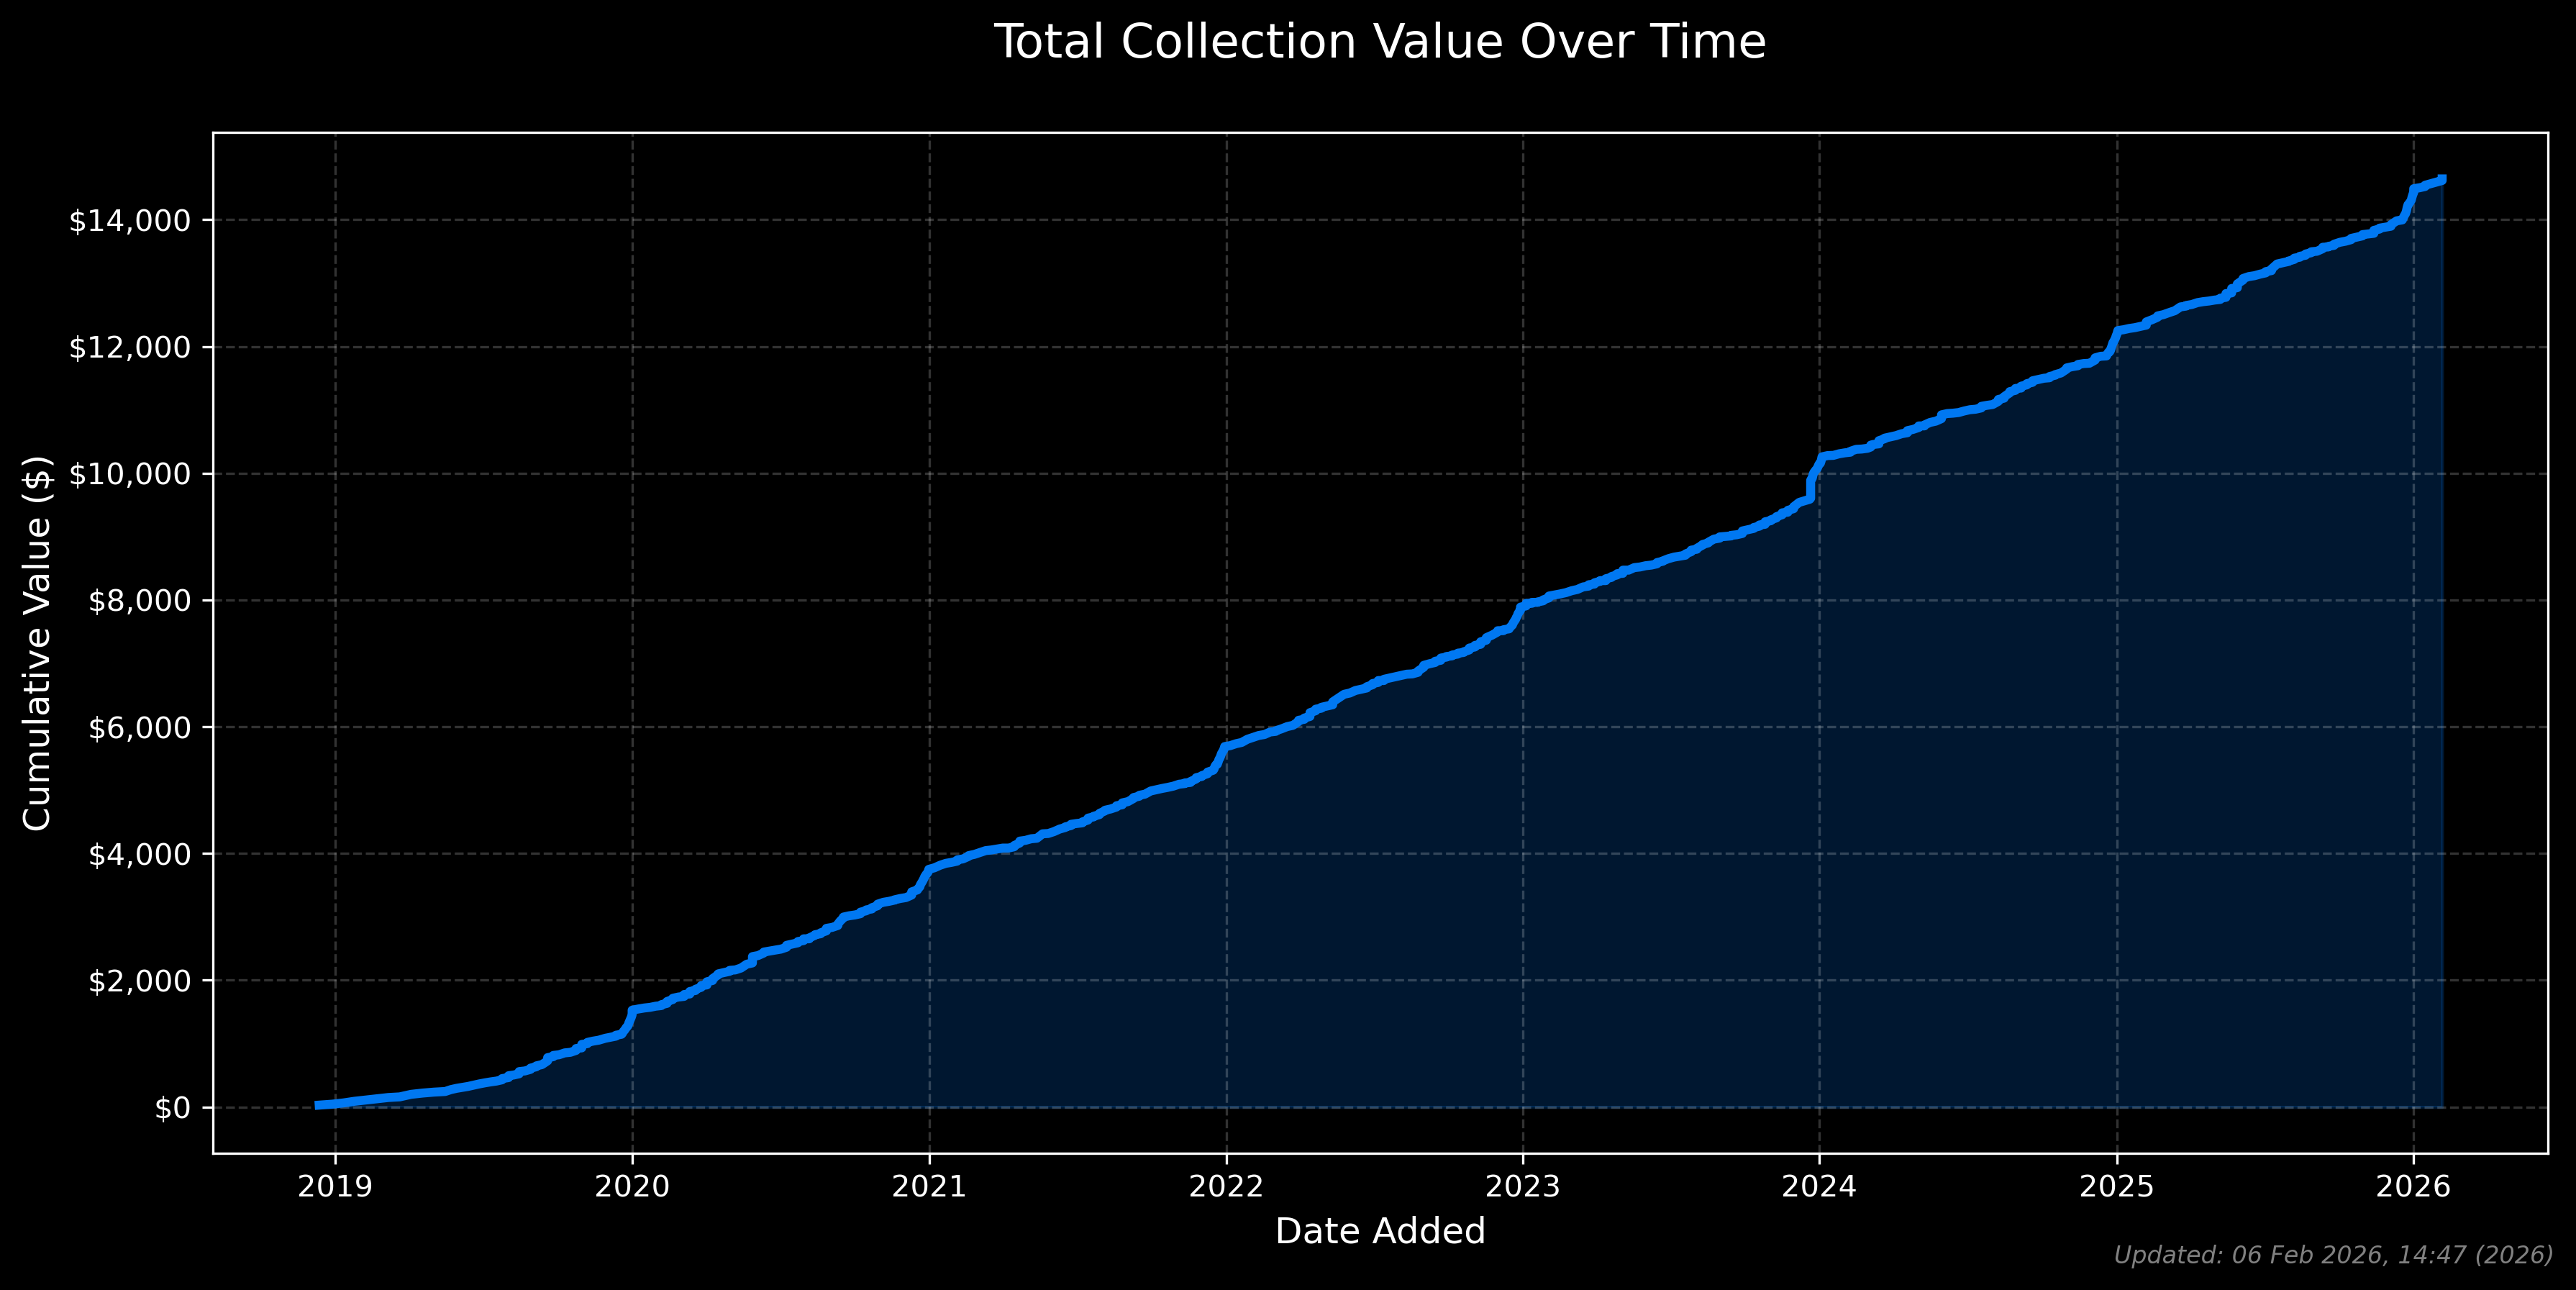

In [25]:
from visualiser import generate_savings_chart

generate_savings_chart(clean_df, output_path="assets/savings_chart.png")
display(Image("assets/savings_chart.png"))

### Consistency Beats Spectacle: Weekly Habit Formation

With **649 total giveaways** since 2018, Epic maintains a reliable weekly cadence rather than relying on occasional large promotions.

This consistency trains users to return regularly, reinforcing habitual platform usage.


📈 Velocity chart saved to assets/velocity_chart.png


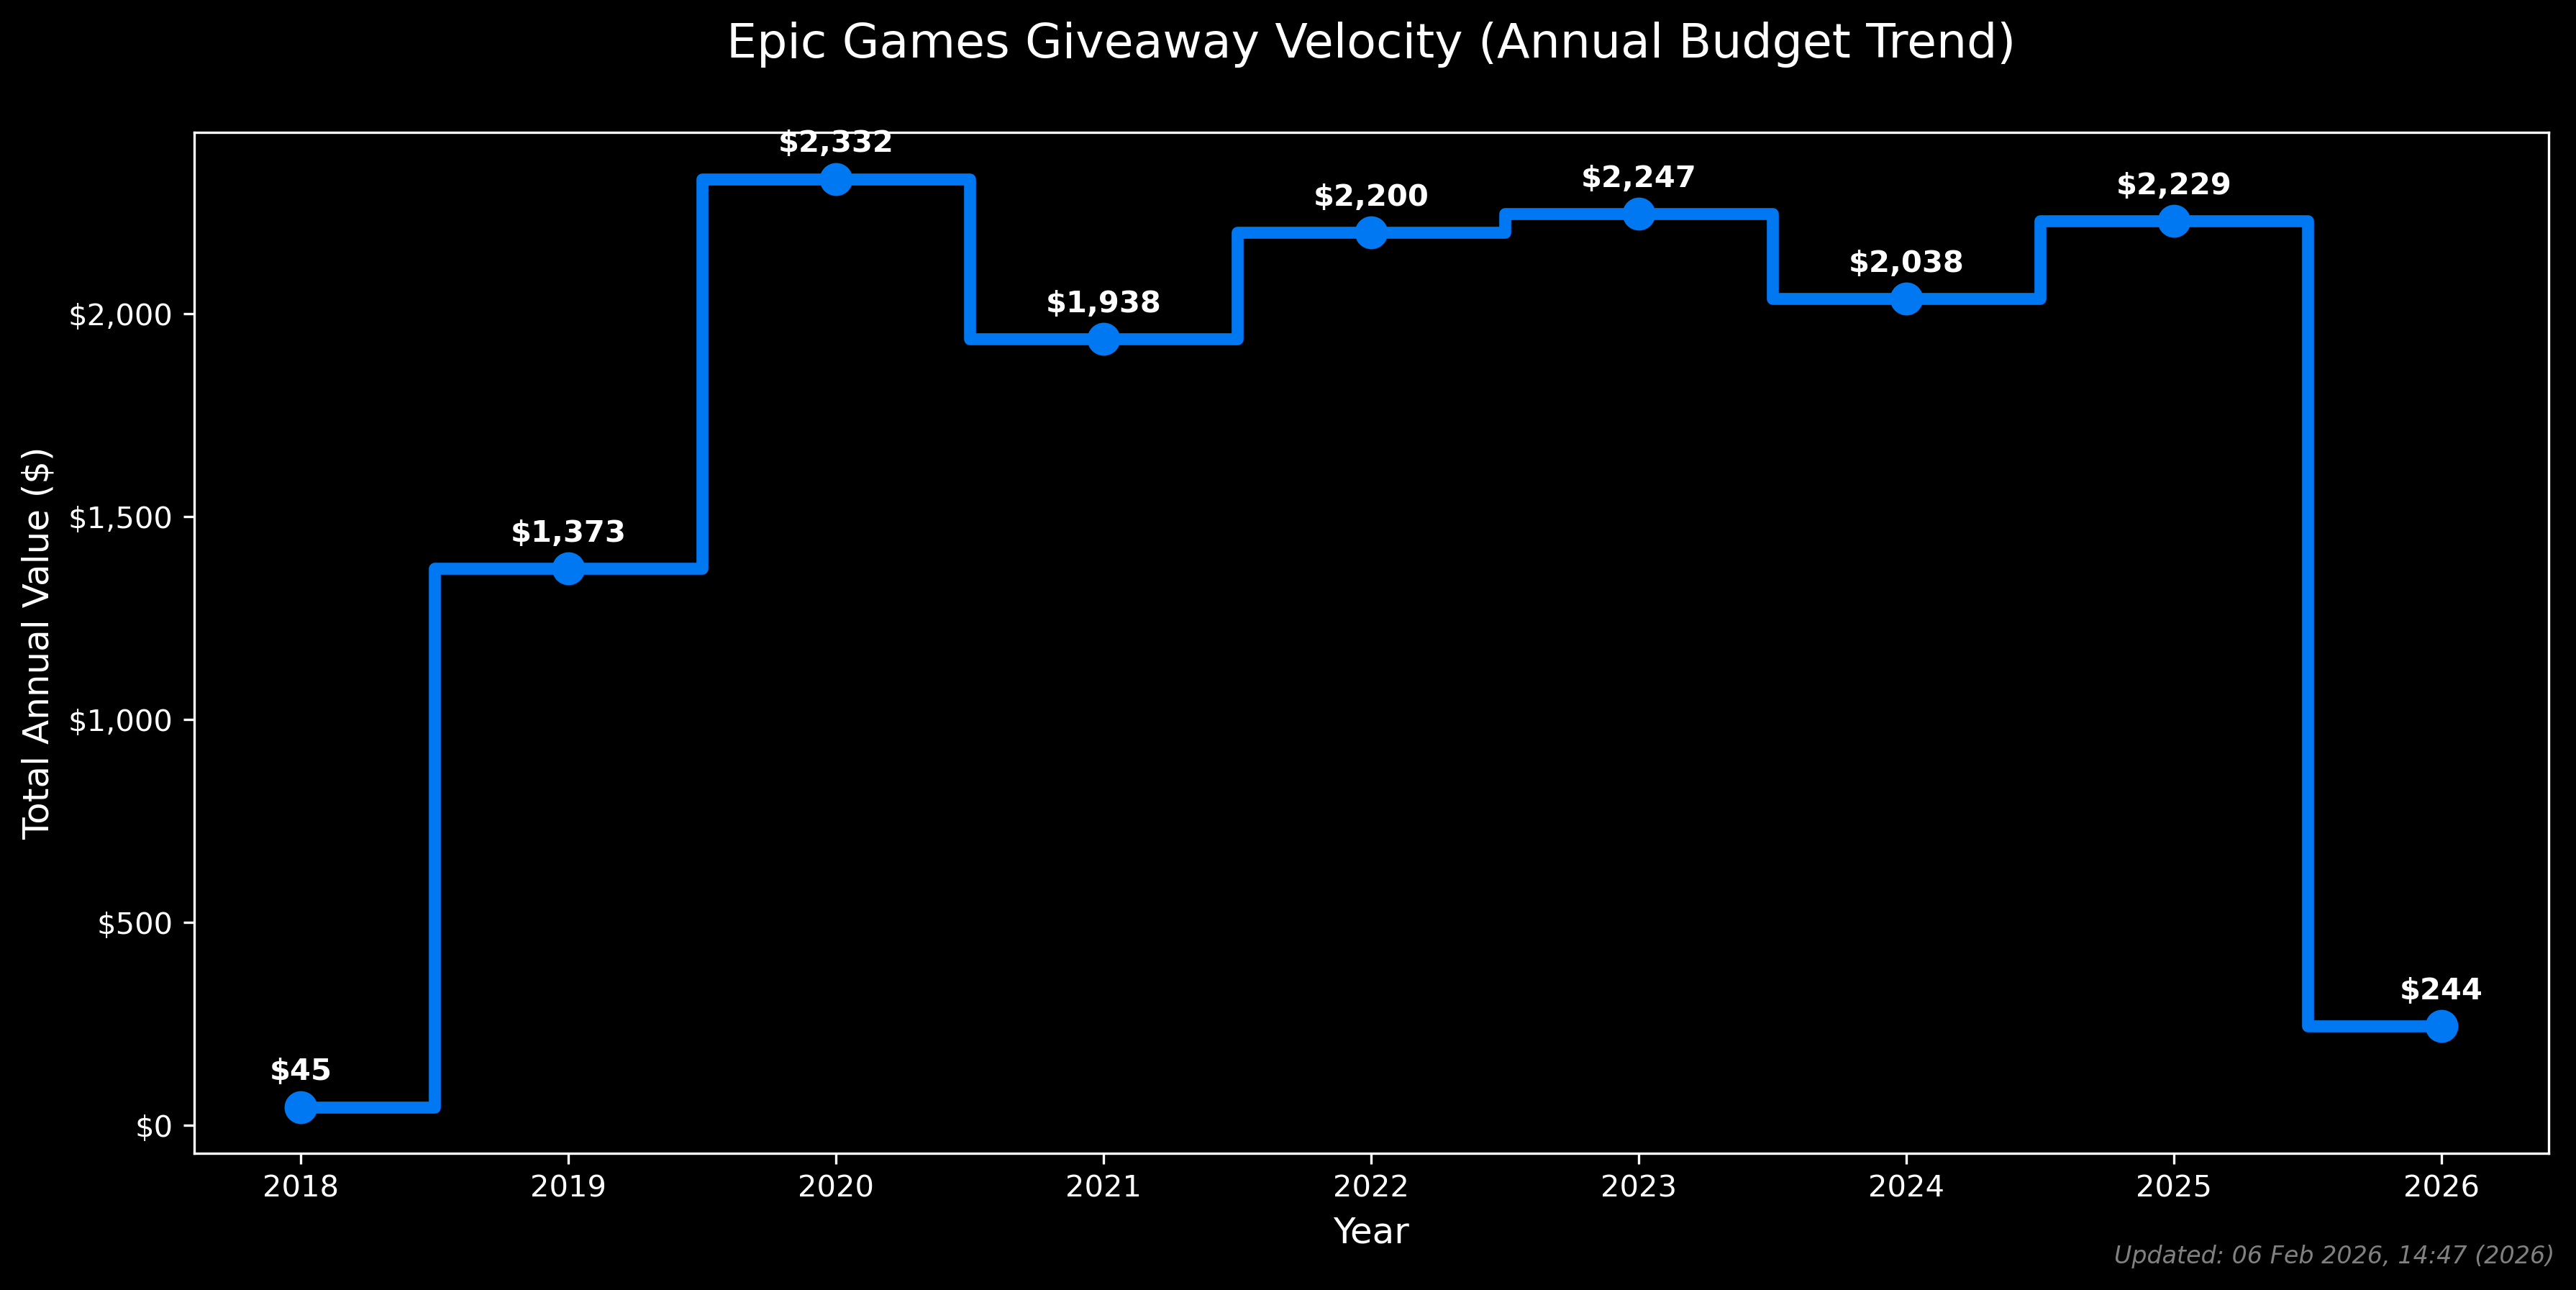

In [26]:
from visualiser import generate_velocity_chart

generate_velocity_chart(clean_df, output_path="assets/velocity_chart.png")
display(Image("assets/velocity_chart.png"))

### Epic Prioritizes Perceived Quality Over Quantity

The average review score across giveaways is **76.8/100**, indicating most free titles are solid, well-reviewed games rather than low-quality filler.

This supports a curation strategy aimed at maintaining perceived platform quality.

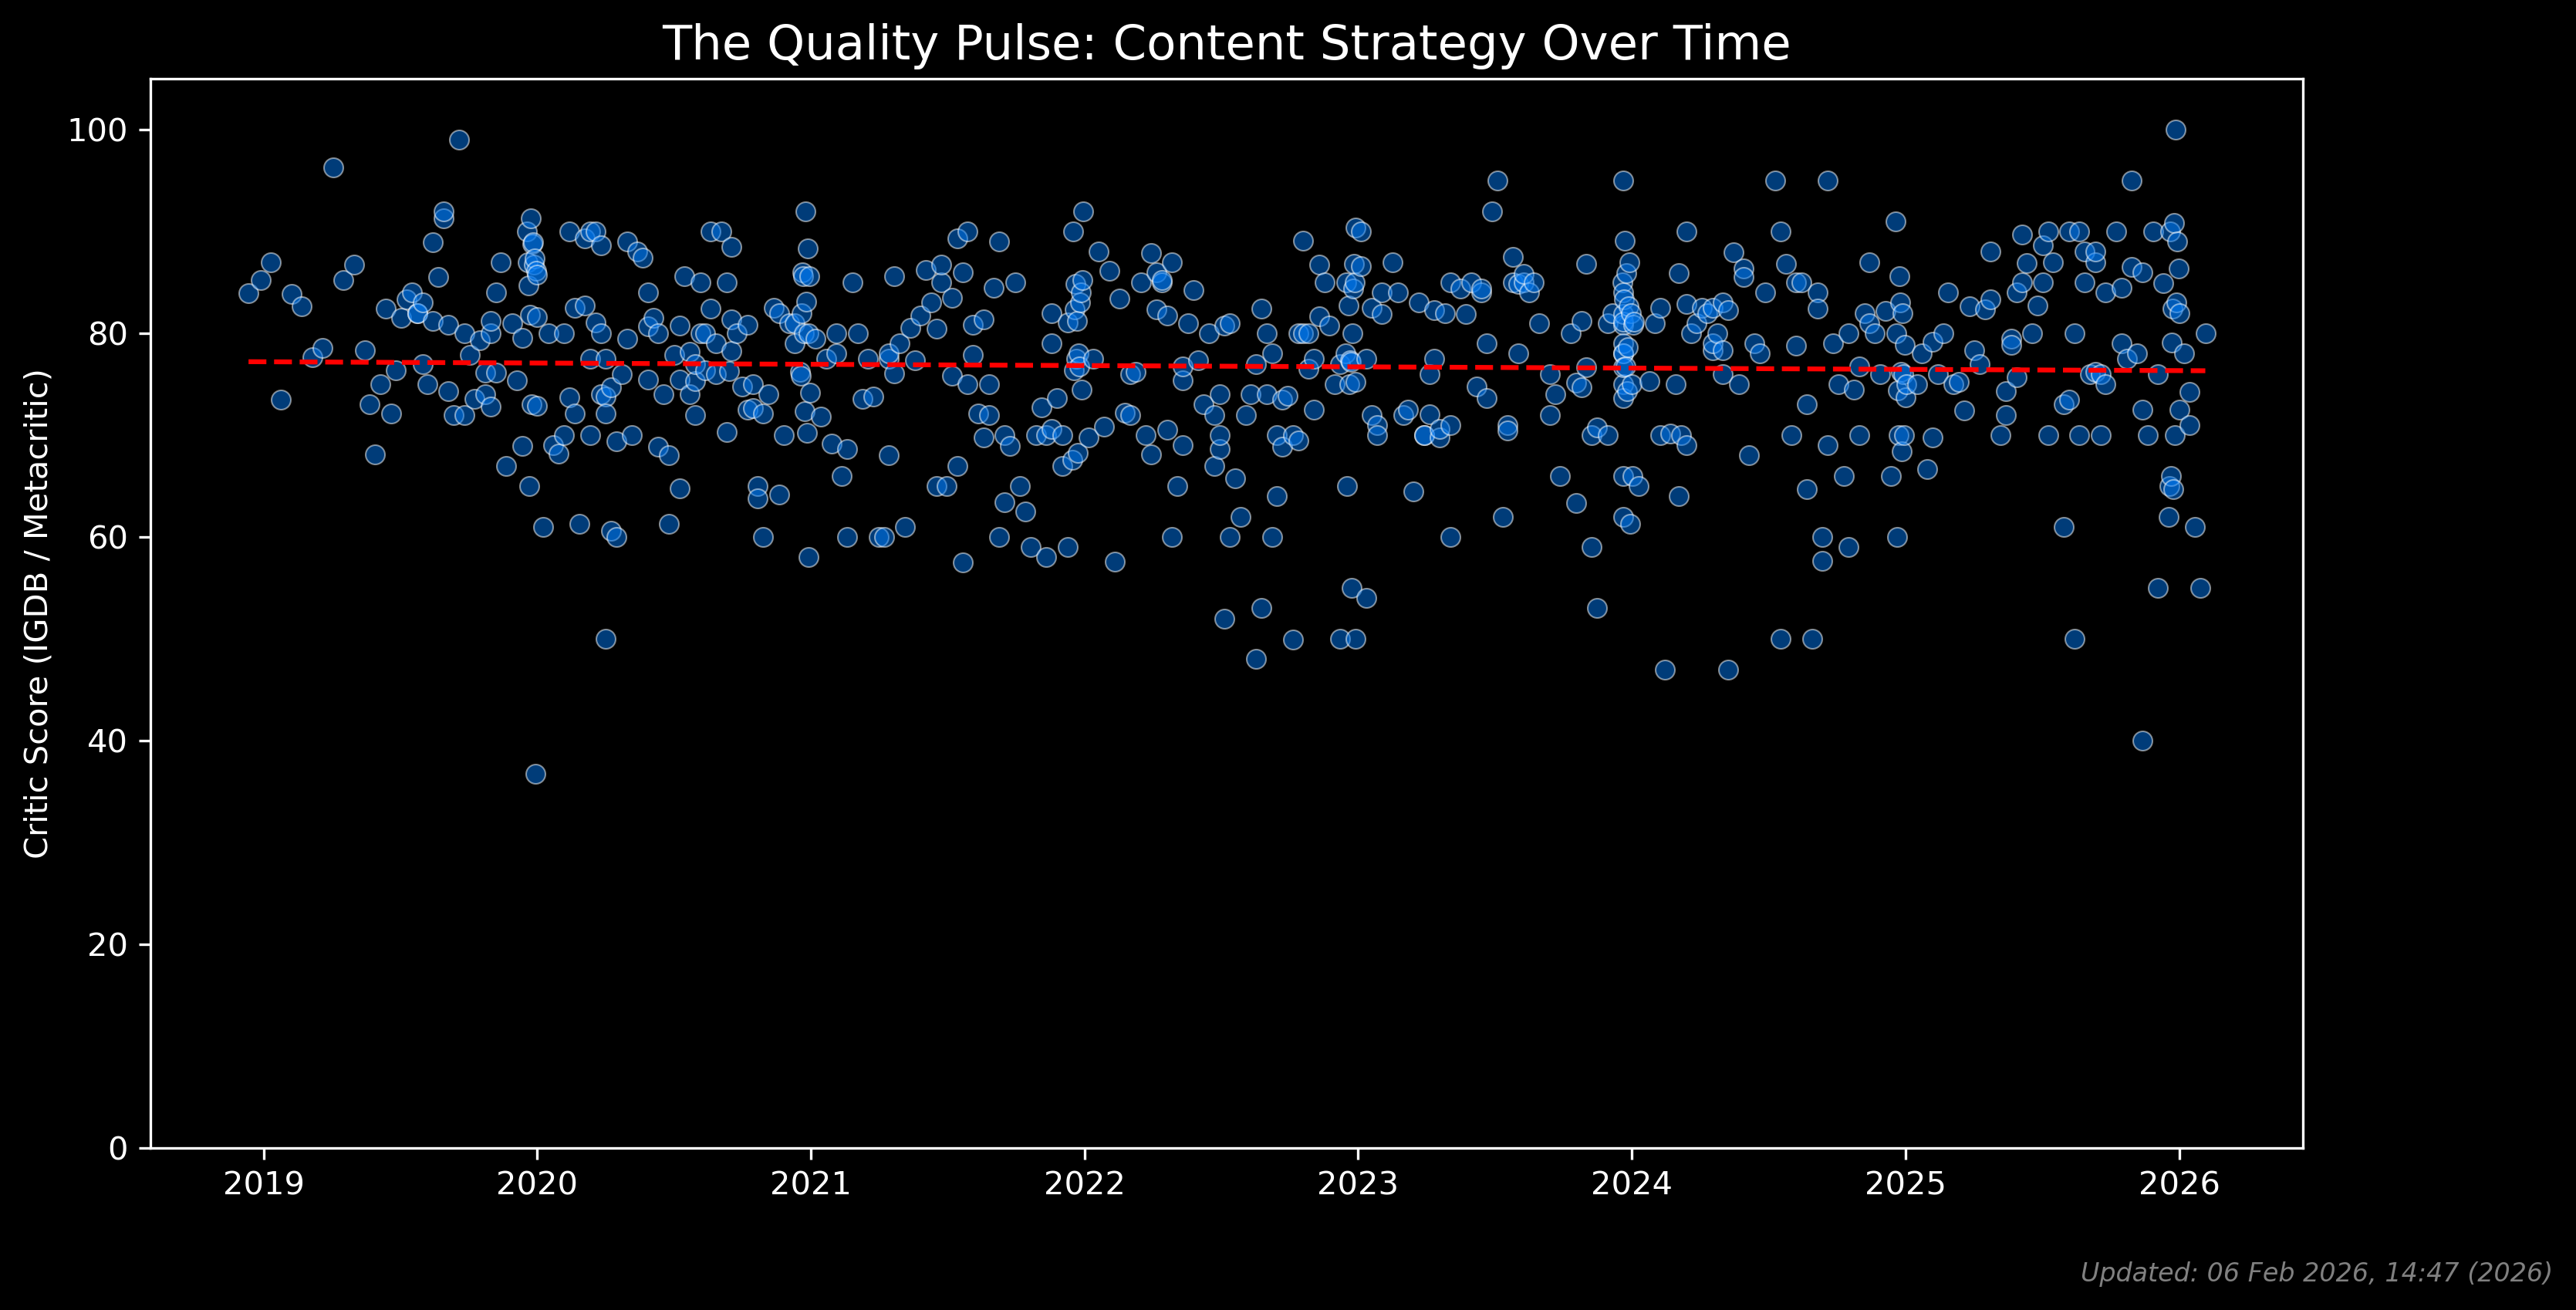

In [27]:
from visualiser import generate_quality_pulse_chart

generate_quality_pulse_chart(clean_df, output_path="assets/quality_pulse.png")
display(Image("assets/quality_pulse.png"))

### High-Cost Giveaways Cluster Around Peak Retail Seasons

December alone accounts for over **$3,300 in historical giveaway value**, making it the most generous month.

Epic appears to concentrate expensive giveaways during major shopping and holiday periods when user attention is highest.


2026-02-06 14:47:36,132 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-06 14:47:36,132 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


📈 Monthly trends chart saved to assets/monthly_value.png


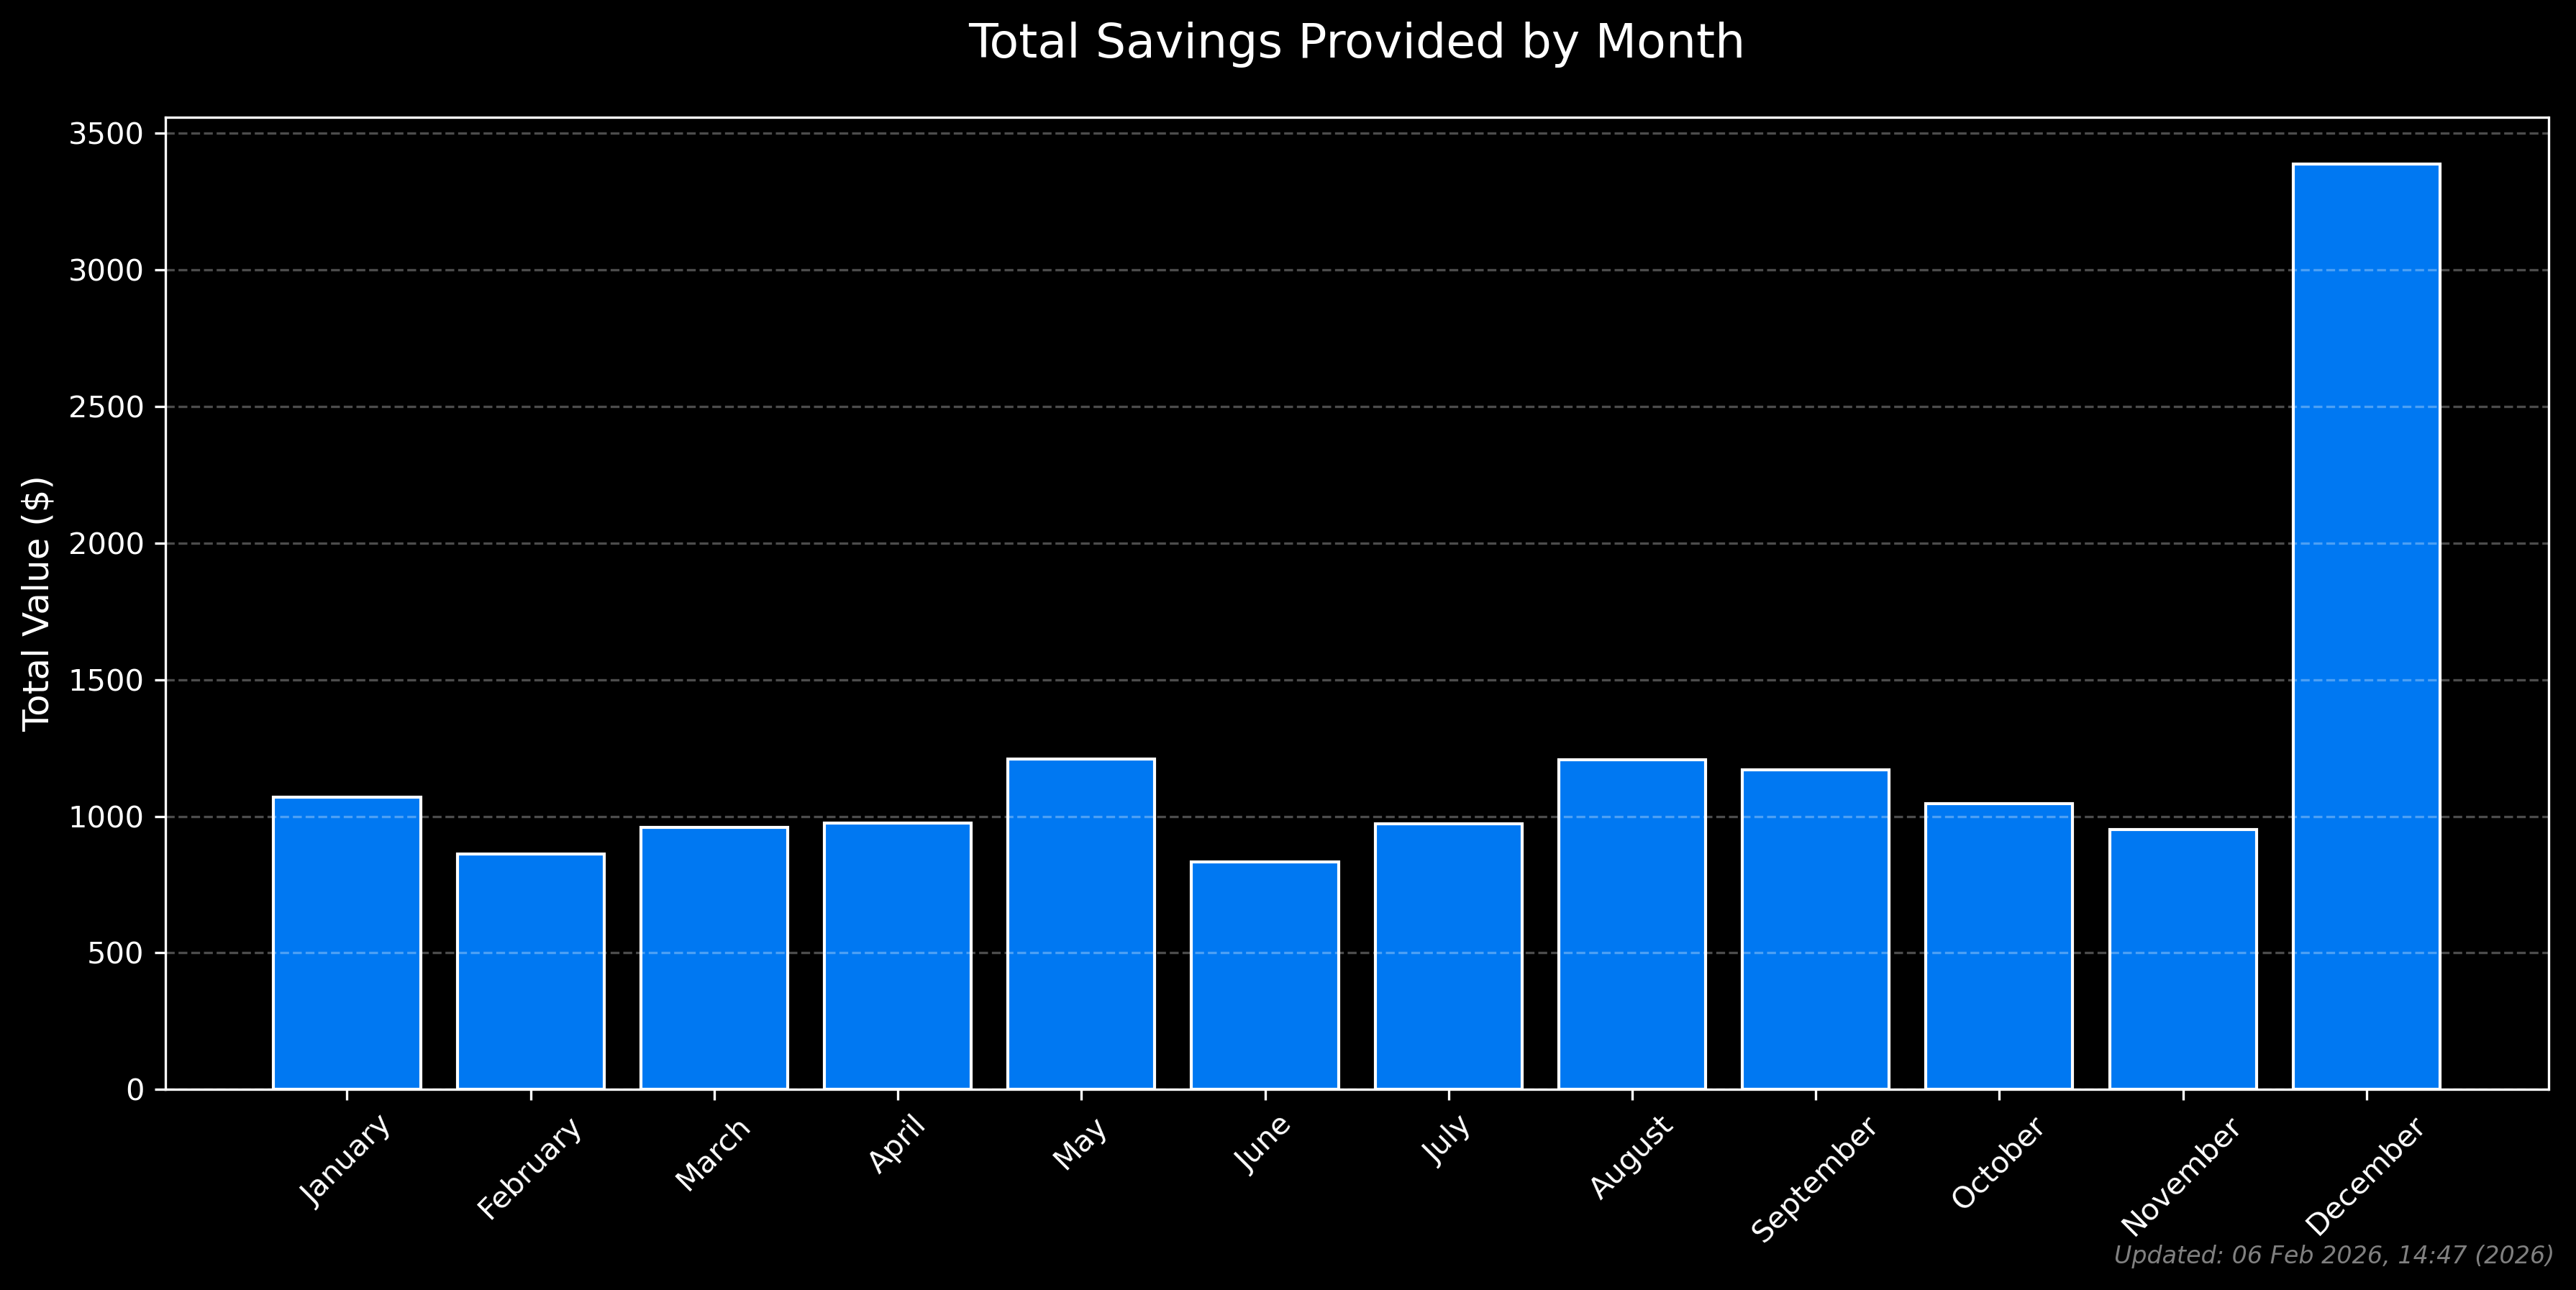

In [28]:
from visualiser import generate_monthly_bar_chart

generate_monthly_bar_chart(clean_df, output_path="assets/monthly_value.png")
display(Image("assets/monthly_value.png"))

### Most Giveaways Build the Library, Not Market Sequels

Only **2.6%** of giveaways fall within the Strategic Hype Window (0–90 days before a sequel or DLC).

This indicates most giveaways are intended to grow the permanent user library rather than directly promote upcoming releases.


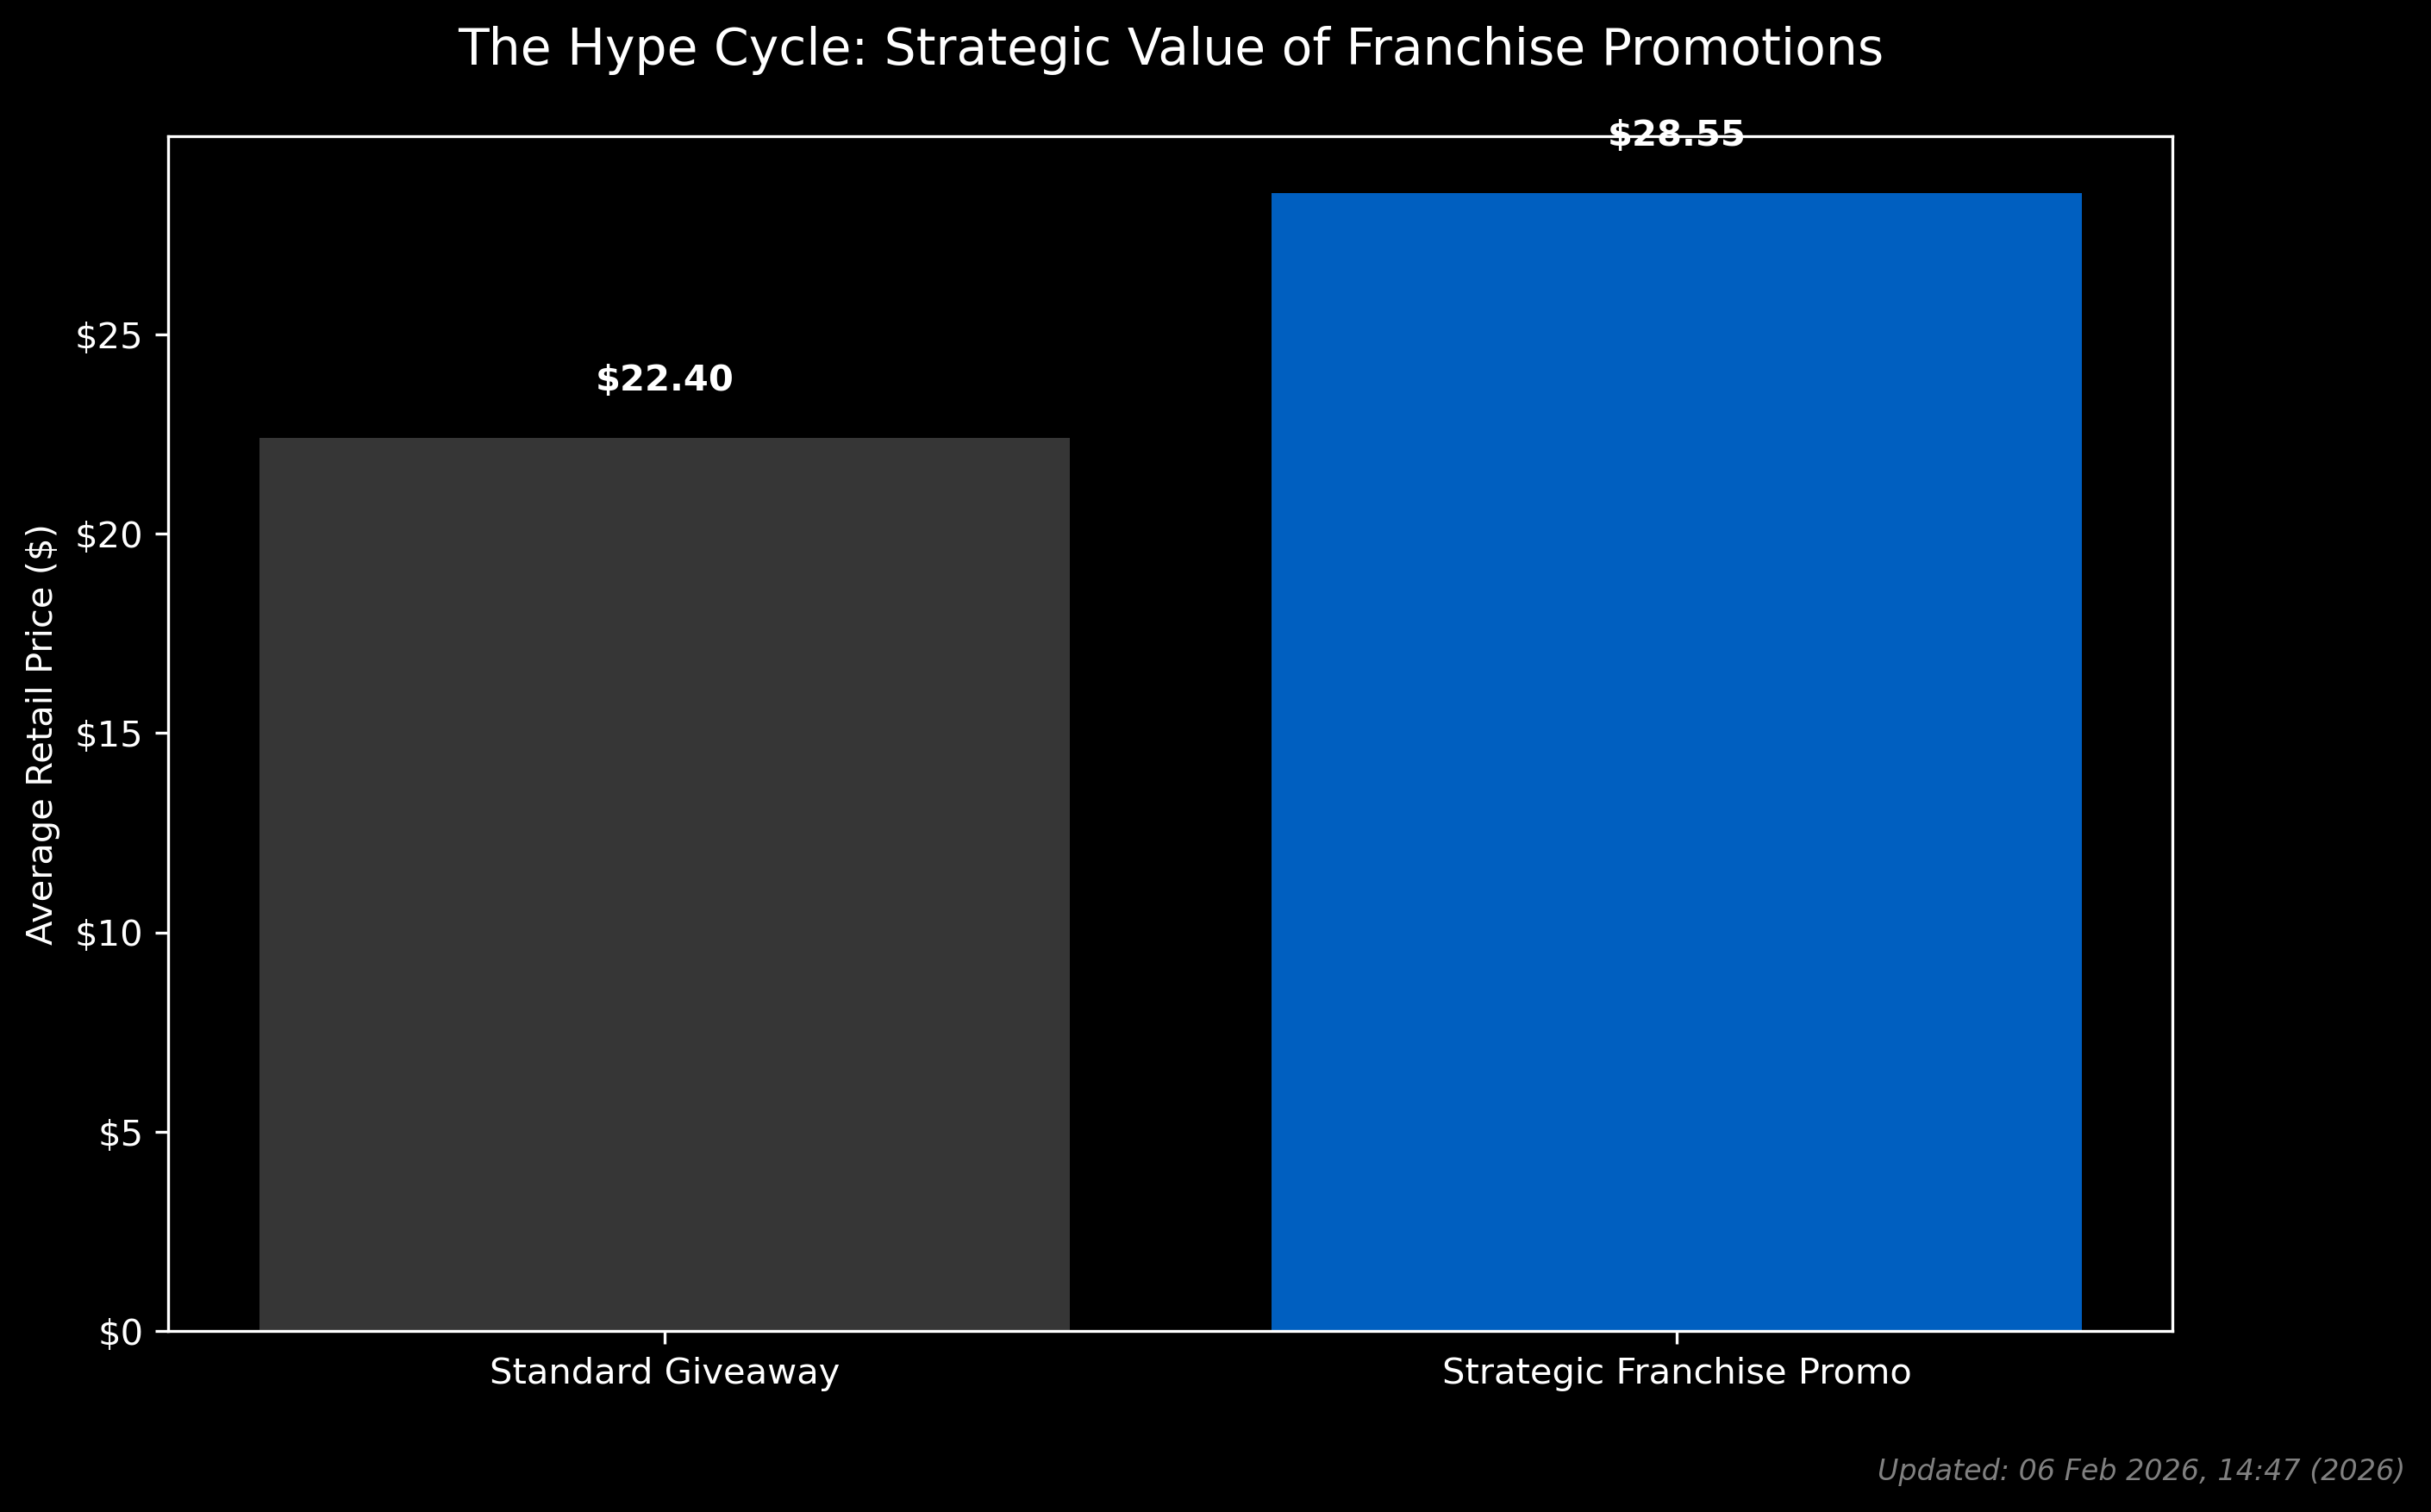

In [29]:
from IPython.display import Image, display
from visualiser import generate_hype_cycle_chart

generate_hype_cycle_chart(clean_df, output_path="assets/hype_cycle.png")
display(Image("assets/hype_cycle.png"))

## Conclusion

Epic’s giveaway program looks less like a short-term promotion and more like an ongoing way to bring new users onto the platform.

Instead of trying to maximise revenue from individual games, Epic appears willing to take short-term losses in order to offer high overall value, encourage users to return each week, and help players build large personal libraries.

Most giveaways come from high-quality indie and mid-tier titles, while older AAA games appear more occasionally and often around major events. This suggests Epic is trying to deliver strong perceived value in a cost-efficient way. The fact that very few giveaways happen close to sequel releases also indicates that most free games are meant to grow the platform’s library rather than directly advertise upcoming titles.

Overall, the data suggests Epic is focused on long-term user retention and ecosystem growth, positioning the Epic Games Store as a serious competitor in digital distribution rather than a store that depends on selling each game for profit.
